# 🧠 PyTorch Computer Vision
---
This notebook provides a comprehensive introduction to **PyTorch**, covering essential topics, theory, functions, and practical examples. 

📘 **Official Documentation**: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

📘 **Official Pytorch Cheatsheet**: [https://docs.pytorch.org/tutorials/beginner/ptcheat.html](https://docs.pytorch.org/tutorials/beginner/ptcheat.html)

📘 **Notebook Resource**: [https://www.learnpytorch.io/04_pytorch_custom_datasets/](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

---

## 📑 Contents
01. Import PyTorch and setting up device-agnostic code
02. Getting a dataset (Food101)



# 01. Import PyTorch and setting up device-agnostic code

In [1]:
# Import PyTorch
import torch
from torch import nn

torch.__version__

'2.7.1+cu118'

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 02. Getting a dataset

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

Let's write some code to download the formatted data from GitHub.

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')

else:
    print(f'{image_path} does not exits, creating one...')
    image_path.mkdir(parents=True,
                     exist_ok=True)
    
with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak, and sushi data...')
    f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)


data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


# 03. Data exploration and preparation 

In [3]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [5]:
# Setup train and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 3.1 Visualize Image

Steps:
1. Get all image paths
2. Pick random image path using python's `random.choice()
3. Get image class name using pathlib.Path.parent.stem
4. Open image with python's PIL
5. Show image and print metadata

Total image paths: 300
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


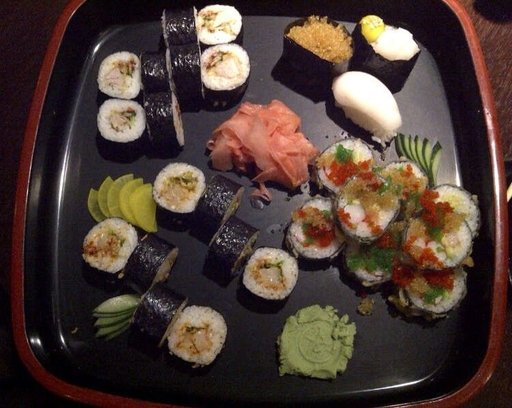

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Total image paths: {len(image_path_list)}')
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

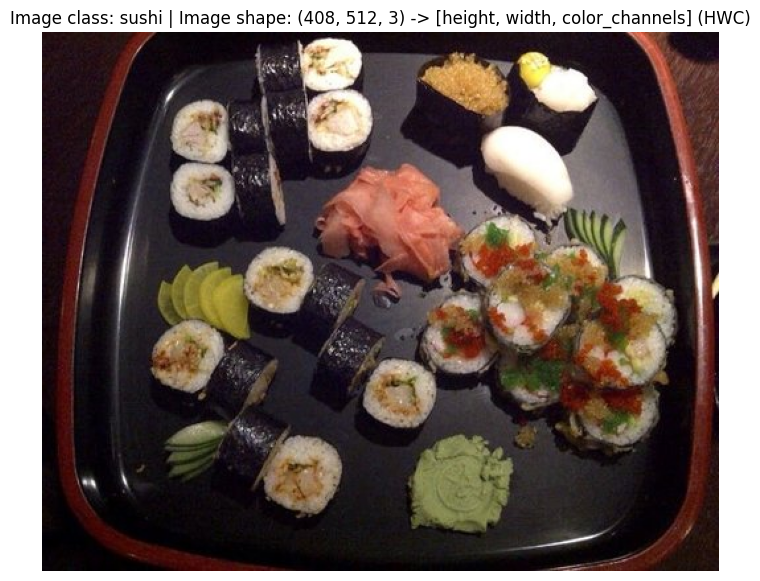

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turns the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

# 04. Transforming Data

In order to use our image data with PyTorch, we need to perform a few steps:
1. Turn target data into tensors
2. Turn tensors into `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`
 

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 4.1 Transformaing data with `torchvision.transforms`

In [12]:
# Write a transform with image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),            # Resize image
    transforms.RandomHorizontalFlip(p=0.5),     # Flit images horizontally
    transforms.ToTensor()                       # Turns image into torch.Tensor
])

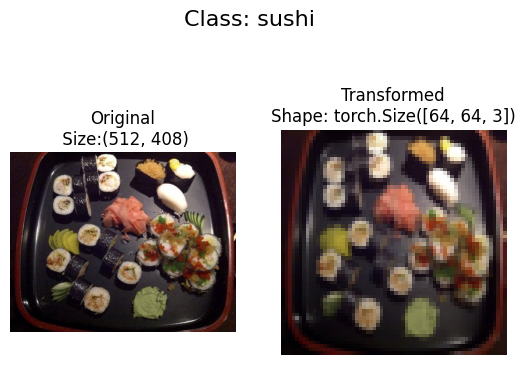

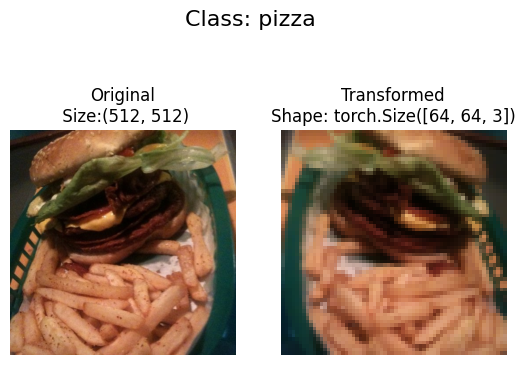

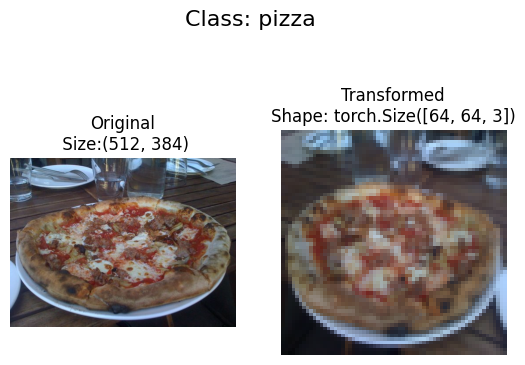

In [24]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Select random images from a path of images and loads/transforms them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\n Size:{f.size}')
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)         # (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, seed=42)

# 05. Loading image data using `ImageFolder`

In [25]:

# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,     # transform for the data
                                  target_transform=None)        # transform for the labels

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,     # transform for the data
                                  target_transform=None)        # transform for the labels

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [29]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [30]:
# Get class dicts
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check lengths of our dataset
len(train_data), len(test_data)

(225, 75)